# Evidence accumulation lab

## Introduction
In this lab, we'll discuss how computational models are used in cognitive neuroscience, and we'll look at how one class of models, **Drift Diffusion Models**, is used to express and test hypotheses about visual perception. By the end of this lab, you should have a better understanding of:

1. What models are, and how they are used in cognitive neuroscience
2. How Drift Diffusion Models work, and what they capture about the data 
3. How to use models to make predictions about behavior

### What is a computational model?

**Computational models** are abstract, mathematical descriptions that strip down the thing being described into its essential parts. For example, the map of Stanford on your smartphone is a model of the Stanford campus: it gives you essential information about the campus that you need to navigate. Models are useful, first, precisely because they condense complex, messy information into a simpler representation—if your map was instead exactly as large and detailed as the real Stanford campus, it would not help you get to class any faster.

You can think of computational models as a mathematical language for expressing theories. In fact, you may have already seen computational models in some of your other classes. For example, in your physics class, you may have seen the following equation used to describe the motion of a cannonball whizzing through the air:

![](human-cannonball.jpg)
$$y(t) = y_0 + v_y t + \frac{1}{2}at^2$$

We can use this equation to make precise predictions about where the cannonball will be at each point in time. Run the code below to see the equation in action:

**Hint:** This Jupyter notebook uses a mix of code and prose. To run each chunk of code, select the chunk and press Shift + Enter. In the problems below, your code might not run until you have successfully solved the problem.

<IPython.core.display.Javascript object>


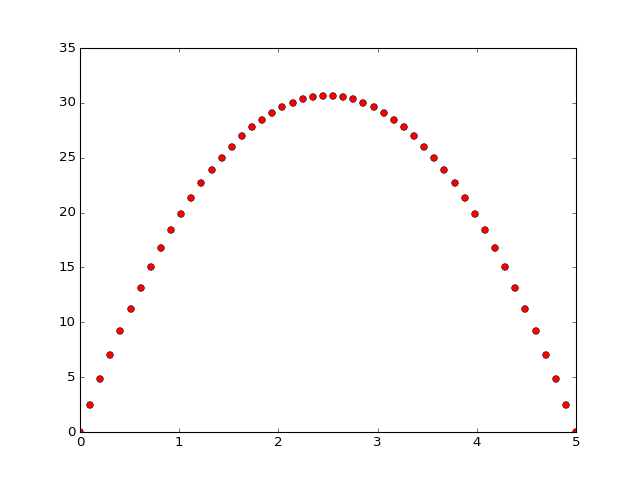

In [1]:
%matplotlib nbagg

'''
First, we need to set up our environment...
Press Shift + Enter to run the commands in this chunk of code, and be sure to run this before you try running
anything else!
'''

import numpy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation
import matplotlib.cm as cmx

'''
Launching the cannonball
'''

# Initial conditions of the cannonball
# (Assume the cannonball is moving horizontally at a constant velocity)
y_0 = 0; # Vertical position 
v_y = 24.5; # Vertical velocity
a_y = -9.8; # Vertical acceleration (due to gravity)

x_0 = 0; # Horizontal position
v_x = 1; # Horizontal velocity
a_x = 0; # Horizontal acceleration

# Equations describing 2D motion of the cannonball over time:
tm = numpy.linspace(0,5)
x_t = lambda t: x_0+v_x*t+ .5*a_x*(t**2)
y_t = lambda t: max(y_0 + v_y*t + .5*a_y*(t**2), 0) # Vertical (assuming the ground is 0, and the ball can't go below)
x = list(map(x_t, tm))
y = list(map(y_t, tm))

# Plotting the motion of the cannonball
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

ax.plot(x,y, 'ro')

plt.show()

Compare the equation above to an analogous verbal model, such as "Cannonballs travel through the air in an arc." What advantages might the computational model have over the verbal model? All models make some simplifying assumptions—what details of the cannonball's trajectory does the equation neglect?

Computational models are used throughout the sciences to explain and predict complex phenomena, such as the trajectory of a hurricane, the ups and downs of the stock market and, in cognitive neuroscience, the computations perfomed by the 100 billion neurons in your brain. In this lab, we'll look at one particular class of model called **Drift Diffusion Models**.

### What are Drift Diffusion Models (DDMs)?

Drift Diffusion Models are a way of modeling rapid, noisy decisions between two alternatives. In class, you saw how these models are used to model some aspects of perception, such as motion detection. You might think that *seeing* is very different from *decision-making*—but, actually, your brain is constantly making split-second decisions to interpret what you are seeing. For example, just think of the many decisions you make while driving: your brain isn't hard-wired with "car detectors," but it can use information about the motion from other cars to infer whether you are going at the same speed as the other cars, whether you have enough room to change lanes, or how far away you are from your exit.

In the lab, neuroscientists use much simpler decisions to study how these fast, complex perceptual decisions are made. In class, you saw one such experiment, carried out by Professor William Newsome's lab at Stanford: macaques were shown moving dots on a screen, and they had to decide whether the dots were predominantly moving to the left or to the right. The task was made harder or easier by changing the proportion of dots that were moving in concert:

![](motion_test.gif)

DDMs describe the macaque's perceptual decision-making, essentially, as a process where evidence is noisily accumulated in favor of one of two alternatives ("left" or "right"). What does it mean to accumulate evidence? Imagine that there is a decider neuron that is counting the "votes" cast by other, motion-detecting neurons. At each timestep, it reads a spike from a neuron that codes either leftward motion (casting one vote for "left") or rightward motion (casting one vote for "right"). This neuron continues to count votes until it accumulates enough evidence for one of the two options and makes its decision. You should have this image in mind, as we saw in lecture:

![](integrator.png)

<div style = "background: #fffac8; padding: 10px;">
<h3>Suggestions for TA's</h3>

<p>After you've gone through the background of the lab as a single group, split students into smaller groups to work through the problems. Make sure to rein in how much time they spend in each problem—one way to run the lab, for example, is to give all groups a certain amount of time to answer the problem, and then "check in" after a certain amount of time, even if not all groups have finished.</p>
</div>

## Problem 1: Simulating a single decision
So, the basic idea behind DDMs is that you are accumulating evidence by successively sampling "votes" from some random process until you reach a threshold in favor of one of the two alternatives. Let's start by simulating a simple DDM, to see how it behaves. 

At each timepoint, the model samples randomly from a Gaussian distribution, and adds the "vote" cast by that random process to the evidence that it's accumulated; the sum of the evidence that it has gathered so far is summarized in its decision variable, d. The model stops counting "votes" when d hits either a top bound, A, or a bottom bound, -B. For this case, we will just have those bounds equidistant from the starting point. So A=B, and we'll just stop the process when the absolute value of d gets bigger than A. 

In the chunk of code below, you'll be completing a function, **randomWalk**, that generates just such a model. When you have successfully completed the function, it should return a list of the value of d at each time point. We'll be using this list to visualize how decision is accumulated over time. Let's have the decision variable, d, start at 0, and set up your model so that it samples from a Gaussian distribution with mean = 0.1 and sd = 1 until it hits the bounds $\pm$10. By convention, for the remainder of the tutorial, we'll say that the model has reached the "correct" decision when it crosses +10, and that it has made an "error" when it crosses -10.

<div style = 'background: #d0e9f0; padding: 10px; width: 800px; margin: 0 auto;'>
<h2>Python tips</h2>
<p>As you can see, the function below builds a <strong>list</strong>, <code>d</code>, that contains the value of the decision variable at each point in time. Python lists are enclosed in brackets: <code>[1, 2, 3, 4]</code>. Our list, d, starts with a single value: <code>[start]</code>. You can control the value of <code>start</code> by passing it as an argument to the function—once you have finished writing your function, you can try running <code>randomWalk(0, 0.1, 1)</code> to feed the function the parameters in the paragraph above. In that case, at the very first time step, the variable <code>d</code> will contain the list <code>[0]</code>.</p>
<p>In order to grow our list, the function contains a <strong>while loop</strong>. The instructions within the while loop will keep  running over and over again, as long as the condition <code>abs(d[-1]) < a </code> is true—that is, as long as the magnitude of the last measured value of d, <code>abs(d[-1])</code>, is less than our decision bound, <code>a</code>. Think about how the list should grow: each time you run the loop, you should take the last measured variable of d, <code>d[-1]</code> , and add to it the evidence generated by sampling from a Gaussian distribution with mean <code>mu</code> and standard deviation <code>sd</code>. (Hint: Google the function <code>numpy.random.normal</code>.) The function <code>d.append(yourAnswerHere)</code> adds the number between parentheses to the end of the list. For example, if you wanted to increase <code>d</code> by +1 every time the loop runs, this code would become: <code>d.append(d[-1] + 1)</code>. But, as you can imagine, adding the same value at every step would give you the same list every time: <code>[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]</code>. Your task is to choose the right value to add to <code>d</code> each time the loop runs.</p>
</div>

Try filling in the code below to complete the model.

In [ ]:
# Generates a random walk
def randomWalk(start, mu, sd, a = 10):
    d = [start]
    
    # Randomly sample evidence until d crosses a decision boundary
    while abs(d[-1]) < a:
        # d.append(yourAnswerHere) # STUDENT
        d.append(d[-1] + numpy.random.normal(mu, sd)) # ANSWER
        
    return d

When you've finished making your model, run the code below to see it in action!

In [ ]:
# Generate a random walk and a vector of timesteps
testWalk = randomWalk(0, .1, 1)
x = range(len(testWalk))

# Animate your random walk!
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

ax.axhline(10, color = 'k')
ax.axhline(-10, color = 'k')
ax.axis([0, len(testWalk), -15, 15])
plt.xlabel('Timesteps')
plt.ylabel('Evidence')

def updateWalk(i):
    line.set_data(x[:i], testWalk[:i])
    return line,

anim = animation.FuncAnimation(fig, updateWalk, len(x), interval=25, blit = True)

plt.show()

## Problem 2: Simulating many decisions

In the problem above, you made a function that accumulates evidence and makes a decision in a single trial. But, to look at how this model is behaving, it's helpful to look at how it behaves over *many trials* and compare those all at once. Fill in the code to manyWalks below—in the end, you should have a function that gives you a list of n random walks.

<div style = 'background: #d0e9f0; padding: 10px; width: 800px; margin: 0 auto;'>
<h2>Python tips</h2>
<p>You don't have to build this function from scratch—you can use the function you've already built, <code>randomWalk()</code>! Remember: <code>randomWalk</code> gives you a list of values of d—that is, it gives you the results of running the model in a single trial. <code>manyWalks</code> should give you a <b>list of lists</b>—that is, it should repeat <code>randomWalk</code> n times and store the output of all of these repetitions in a single list.</p>

<p>The code below contains a <strong>for loop</strong>—this will repeat the instructions within the loop <code>n</code> times. Remember the function we saw in the last problem, <code>d.append()</code>? You can use that to add the results of a new trial to <code>d</code> every time the loop runs.</div>
</div>

In [ ]:
# Generate random walks over n trials
def manyWalks(start, mu, sd, n=1, a = 10):
    d = []
    for trial in range(n):
        # d.append(yourAnswerHere) # STUDENT
        d.append(randomWalk(start, mu, sd, a)) # TEACHER
    return d

Once you've filled in manyWalks, run the code below to see the results of your simulation.

In [ ]:
# Helper functions: generate random greens & reds for prettier plots
def rcol(clr):
    cm = plt.get_cmap('Greens' if clr == 'g' else 'Reds')
    return cm(numpy.random.uniform())

# Plots result of random walk
def showRandomWalk(d):
    # Create figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    try: # Plot many lines
        for trial in range(len(d)):
            ax.plot(range(len(d[trial])), d[trial], alpha = 0.8, color = rcol('g' if d[trial][-1] > 0 else 'r'))
    except TypeError: # Plot a single line
        # Line is green for correct answers, red for incorrect answers
        ax.plot(range(len(d)), d, color = 'g' if d[-1] > 0 else 'r')
        
    # Draw decision boundaries
    ax.axhline(10, color = 'k')
    ax.axhline(-10, color = 'k')
    
    # Show plot
    plt.ylim([-15, 15])
    plt.xlabel('Timesteps')
    plt.ylabel('Evidence')
    fig.show()

# Test case
testMultiWalks = manyWalks(0, 0.1, 1, 100)
showRandomWalk(testMultiWalks)

The graph above shows the result of running the model with the same parameters many, many times. Looking at this graph, you should notice two things. First, the model sometimes reaches the correct answer (green lines), and sometimes it reaches the wrong answer (red lines). Second, even when it reaches the correct decision, the model might reach the same decision after a different number of steps. This is a key idea behind Drift Diffusion Models: decision-making is inherently a noisy, variable process. So, we're not so interested in whether the model is right or wrong on a *particular* trial; rather, we'll look at how the *distribution* of correct responses and the distribution of reaction time (how quickly the model reaches an answer) change under different conditions.

## Problem 3: Putting it all together

(a) But first, we'll need some way to quickly sum up the model's performance and reaction time over many trials. In the chunk below, you'll see three useful functions: getCorrect, getError, and getRT. You can pass the output of manyWalks into getCorrect and getError to get the number of correct and incorrect trials, respectively, and to getRT to get a list of reaction times (one for each trial).

In [ ]:
# Calculates the number of correct trials
def getCorrect(trials):
    return len([trial for trial in trials if trial[-1] > 0])

# Calculates the number of incorrect trials
def getError(trials):
    # return None # FILL THIS IN
    return len(trials) - getCorrect(trials)

# Calculates reaction time for all trials
def getRT(trials):
    # return None # FILL THIS IN
    return [len(trial)-1 for trial in trials]

Now, let's start using these functions to describe the output of the model. 

(b) In how many trials did the model reach the right choice, and in how many trials was it wrong?


In [ ]:
# Use this space, and the functions above, to calculate the answer
# ANSWER (TEACHER):
n_correct = getCorrect(testMultiWalks)
n_error = getError(testMultiWalks)
print('Out of {} trials, {} were correct, and {} were incorrect'.format(len(testMultiWalks), n_correct, n_error))

(c) What is the distribution of reaction times for correct and incorrect responses? Run the code below to plot the reaction times. 

Bonus: Can we get a reliable distribution of reaction times for incorrect trials? Why or why not? If you wanted to get a better idea of the distribution of reaction times for incorrect trials—without changing the strength or noise of the evidence—what would you change about the arguments to <code>multiWalks</code>?

In [ ]:
def plotRTs(trials):
    # Make a new figure
    fig = plt.figure(figsize = (8,6))
    
    # Separate reaction times by correct and incorrect trials
    correct_rts = getRT([trial for trial in trials if trial[-1] > 10])
    error_rts = getRT([trial for trial in trials if trial[-1] < -10])

    # Plot correct trials
    ax1 = fig.add_subplot(211)
    ax1.hist(correct_rts, bins = 20)
    ax1.set_title('Reaction times (correct trials)')
    plt.xlabel('Reaction time')
    plt.ylabel('Count')

    # Plot incorrect trials
    ax2 = fig.add_subplot(212)
    ax2.hist(error_rts, bins = 20)
    ax2.set_title('Reaction times (error trials)')
    plt.xlabel('Reaction time')
    plt.ylabel('Count')
    
    # Show plot
    plt.subplots_adjust(hspace = .5)
    plt.show()

# Test case
plotRTs(testMultiWalks)

(d) Now, let's put it all together. Using all of the functions you've made, try playing around with the strength (<code>mu</code>) and noise (<code>sd</code>) of the sensory evidence. If you wish, you can also change the starting point of the model (<code>d[0]</code>) and the decision bounds (<code>a</code>). Try systematically experimenting with these parameters—use the space below to test the model under different parameters and to write your observations. Based on the settings you have tested, what factors affect accuracy and reaction time?

<div style = "background: #fffac8; padding: 10px;">
<h3>Suggestions for TA's</h3>

<p><strong>From the Gardner Lab tutorial:</strong> The mean of the random process will cause you to accumulate larger increments of evidence for the correct decision. It will cause you to more often reach the correct upper bound “A” and will make you do that faster. You could also change the standard deviation of the gaussian process. If it had 0 standard deviation, then there would be no noise at all and you would always go predictably in a straight line up to the bound. You could also make the bounds farther away from the starting point. This will make the process have to traverse farther to get to the decision, making it less likely that you will get false alarms at the other boundary. But, this comes at a cost - it will make the decisions take a longer time to get to the bound. This is your classic speed-accuracy trade-off.</p>

<p>(This might be a good problem to do with the whole class, rather than split into groups!)</p>
</div>

<div style = 'background: #d0e9f0; padding: 10px; width: 800px; margin: 0 auto;'>
<h2>Python tips</h2>
<p>The nice thing about packaging all our work into functions is that you can now change the arguments that you pass to each function to look at the model output under different conditions. Remember, so far we have implemented the following functions:</p>
<ul>
<li><code>randomWalk(start, mu, sd, a)</code></li>
<li><code>manyWalks(start, mu, sd, n, a)</code></li>
<li><code>showRandomWalk(manyTrials)</code></li>
<li><code>getCorrect(manyTrials)</code></li>
<li><code>getError(manyTrials)</code></li>
<li><code>getRTs(manyTrials)</code></li>
<li><code>plotRTs(manyTrials)</code></li>
<p>As you change each of the parameters, think about what the parameter represents. For example, in our motion decision-making task, what is the real-world equivalent of <code>mu</code>? How does changing <code>mu</code> affect the process of evidence accumulation?
</ul>
</div>

*[Write your observations here]*

## Problem 4: Comparing the model to neural data

Now that we have learned a little bit about how the model behaves, let's compare the model predictions to Professor Newsome's data. In their experiment, the strength of the evidence (mu), is the product of two factors: the coherence of motion, C, that is known and systematically manipulated; and a scaling parameter, k, that is fit to the data. So,

$$ \mu = kC $$

For the exercises below, let's use the parameters that the experimenters found by fitting to the data: k = 0.426 (scaling parameter), A = 22.811 (decision bounds).

(a) Starting with C = 0.05, let's adapt manyWalks so that we can plot the average value of d across many *correct* trials. This is a little tricky, because different trials might take a different number of steps—so we'll assume that, once d reaches one of the bounds, it will go no further (that is, we'll make each trial last the same number of steps, and fill in missing values with the value of the bound).

In [ ]:
k = 0.426 # scaling parameter
C = 0.05 # motion coherence
A = 22.811 # decision bounds

# averageWalk simulates many trials with mu = k*C, then returns a path that is the average of all the correct trials
def averageWalk(trials):
    # Take out correct trials only
    correctTrials = [trial for trial in trials if trial[-1] > A]
    
    # Find out maximum length
    maxTrials = max(getRT(correctTrials)) + 1
    
    # fullWalks will contain all of our trials + padding (to make them the same length)
    fullWalks = []
    
    # Take each trial in trials, add padding, and add the full walk to fullWalks
    for trial in trials:
        fullWalk =  trial + ([A] * (maxTrials - len(trial)))
        fullWalks.append(fullWalk)
    
    # avgWalk will contain the average of all the walks in fullWalks
    avgWalk = [numpy.mean([walk[i] for walk in fullWalks]) for i in range(maxTrials)]
    return avgWalk
        
# Test case
w = manyWalks(0, k*C, 1, 100, A)
avg_w = averageWalk(w)

Let's plot our average walk. C = 0.05 is really low motion coherence, with only 5% of the dots moving in concert. How do you think this curve changed as Newsome & his colleagues changed the motion coherence (C)?

In [ ]:
def plotAverage(avg_walks, Cs):
    # Open a new plot
    fig = plt.figure(figsize = (8,6))
    ax = fig.add_subplot(111)
    
    # Plot each average walk as a separate line, and label the line according to motion coherence
    for i in range(len(avg_walks)):
        ax.plot(range(len(avg_walks[i])), avg_walks[i], label = '%0.1f %%'%(Cs[i]*100))
    
    # Axes
    #plt.xlim([0, 1000])
    plt.xlabel('Timesteps')
    plt.ylabel('Decision variable')
    plt.legend()

    plt.show()

# Let's test this out with our avg_w!
plotAverage([avg_w], [0.05])    

(b) Now, let's put it all together and run our model at different levels of motion coherence. Run the code below—how does it compare to the data from Roitman & Shadlen (2002)?

![](roitmanshadlen.png)

In [ ]:
Cs = [] # Fill in this list!
Cs = [0.0, 0.032, 0.064, 0.128, 0.256, 0.512] # TEACHER

def manyAverages(coherences):
    avg_walks = []
    
    for c in coherences:
        allw = manyWalks(0, k*c, 1, 100, A)
        avg_walks.append(averageWalk(allw))
        
    return avg_walks

plotAverage(manyAverages(Cs), Cs)